In [41]:
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import os
from pytorch_lightning import Trainer
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset


In [42]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
price = pd.read_csv('sample_submission.csv')
test_data = pd.merge(test_data, price, on='Id')
data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [43]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [5]:
# MSSubclass is a categorical variable
data['MSSubClass'] = data['MSSubClass'].astype(str)


In [45]:
# check Missing values
missing_data = data.isnull().sum()

missing_data = missing_data[missing_data > 0]

print(missing_data)
print('Total Length of original data`:', len(data))

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64
Total Length of original data`: 2919


In [46]:
missing_ratio = data.isnull().sum() / len(data)

columns_to_drop = missing_ratio[missing_ratio > 0.3].index

data = data.drop(columns=columns_to_drop)

In [47]:
# check Missing values
missing_data = data.isnull().sum()

missing_data = missing_data[missing_data > 0]

print(missing_data)
print('Total Length of original data`:', len(data))

MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64
Total Length of original data`: 2919


In [48]:
data['MasVnrArea'].fillna(0, inplace=True)
data['BsmtQual'].fillna('NA', inplace=True)
data['BsmtCond'].fillna('NA', inplace=True)
data['BsmtExposure'].fillna('NA', inplace=True)
data['BsmtFinType1'].fillna('NA', inplace=True)
data['BsmtFinType2'].fillna('NA', inplace=True)
data['GarageType'].fillna('NA', inplace=True)
data['GarageFinish'].fillna('NA', inplace=True)
data['GarageQual'].fillna('NA', inplace=True) 
data['GarageCond'].fillna('NA', inplace=True)

data.drop(columns=['Electrical', 'GarageYrBlt'], inplace=True)

C:\Users\Park\AppData\Local\Temp\ipykernel_67220\717532453.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['MasVnrArea'].fillna(0, inplace=True)
C:\Users\Park\AppData\Local\Temp\ipykernel_67220\717532453.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [49]:

imputer = KNNImputer(n_neighbors=5)

data['LotFrontage'] = imputer.fit_transform(data[['LotFrontage']])

print(data['LotFrontage'].head())


0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64


In [50]:
# check Missing values
missing_data = data.isnull().sum()

missing_data = missing_data[missing_data > 0]

print(missing_data)
print('Total Length of original data`:', len(data))
# No more missing value

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
dtype: int64
Total Length of original data`: 2919


In [51]:
data = data.dropna()


# create a new variable 'House Category' based on 'House Style', 'Bldg Type', 'Year Built', and 'Year Remod/Add' for the classification task.

In [52]:
categorical_variables = ['HouseStyle', 'BldgType']
for variable in categorical_variables:
    print(data[variable].value_counts())
    print('-' * 50)


HouseStyle
1Story    1463
2Story     871
1.5Fin     312
SLvl       128
SFoyer      83
2.5Unf      23
1.5Unf      19
2.5Fin       8
Name: count, dtype: int64
--------------------------------------------------
BldgType
1Fam      2413
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: count, dtype: int64
--------------------------------------------------


In [53]:
style_mapping = {
    '1Story': 'One story',
    '1.5Fin': 'One story',
    '1.5Unf': 'One story',
    '2Story': 'Two story',
    '2.5Fin': 'Two story',
    '2.5Unf': 'Two story',
    'SFoyer': 'Split',
    'SLvl': 'Split'
}

building_type_mapping = {
    'TwnhsE': 'Townhouse',
    'Twnhs': 'Townhouse'
}

data['SimplifiedStyle'] = data['HouseStyle'].map(style_mapping).fillna('Other')
data['SimplifiedBuildingType'] = data['BldgType'].map(building_type_mapping).fillna('Other')


data['YearAfterRemod'] = data['YrSold'] - data['YearRemodAdd']


In [54]:


numerical_features = ['YearAfterRemod']
scaler = StandardScaler()
numerical_data = scaler.fit_transform(data[numerical_features])

encoder = OneHotEncoder()
categorical_data = encoder.fit_transform(data[['SimplifiedStyle', 'SimplifiedBuildingType']]).toarray()
categorical_feature_names = encoder.get_feature_names_out(['SimplifiedStyle', 'SimplifiedBuildingType'])

all_features = np.hstack((numerical_data, categorical_data))

dbscan = DBSCAN(eps=0.5, min_samples=50)  
clusters = dbscan.fit_predict(all_features)

data['HouseCategory'] = clusters

print("Cluster labels:", set(clusters))




Cluster labels: {0, 1, 2, 3, 4, 5, -1}


Numerical Summary by Cluster:
              YearAfterRemod                                                 \
                       count       mean        std   min   25%   50%    75%   
HouseCategory                                                                 
-1                      37.0  24.837838  14.024806   0.0   9.0  31.0  35.00   
 0                     776.0  15.820876  17.579537  -1.0   4.0   9.0  18.00   
 1                    1617.0  28.513915  22.276974  -2.0   5.0  30.0  51.00   
 2                     160.0   6.093750   6.916207   0.0   1.0   4.0   9.00   
 3                     191.0  27.392670  14.820958   1.0  13.0  30.0  39.00   
 4                      56.0   5.464286   4.116328   0.0   2.0   5.5   8.00   
 5                      70.0  33.914286   3.570178  23.0  32.0  34.0  36.75   

                     
                max  
HouseCategory        
-1             39.0  
 0             60.0  
 1             60.0  
 2             26.0  
 3             59.0  
 4 

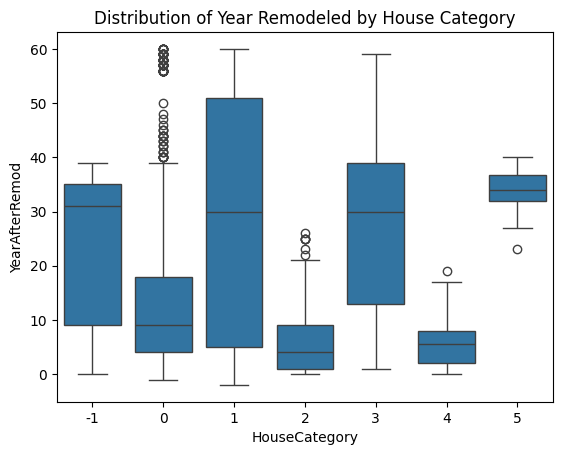

In [56]:


numerical_summary = data.groupby('HouseCategory')[numerical_features].describe()

categorical_summary = data.groupby('HouseCategory')[['SimplifiedStyle', 'SimplifiedBuildingType']].agg(lambda x: x.value_counts().index[0])

print("Numerical Summary by Cluster:")
print(numerical_summary)

print("\nCategorical Summary by Cluster:")
print(categorical_summary)

sns.boxplot(x='HouseCategory', y='YearAfterRemod', data=data)
plt.title('Distribution of Year Remodeled by House Category')
plt.show()


In [57]:
data['HouseCategory'] = data['HouseCategory'].replace(-1, 6)


In [58]:
data['HouseCategory'].value_counts()

HouseCategory
1    1617
0     776
3     191
2     160
5      70
4      56
6      37
Name: count, dtype: int64

In [59]:
data = data.drop(columns=['HouseStyle','BldgType','YearBuilt','YearRemodAdd','SimplifiedStyle', 'SimplifiedBuildingType', 'YearAfterRemod'])


# Encoding

In [61]:


# Drop columns that are not relevant
data.drop(['Id'], axis=1, inplace=True)

In [74]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd

predictors = data.drop(['SalePrice', 'HouseCategory'], axis=1)
target = data[['SalePrice', 'HouseCategory']]

categorical_features = predictors.select_dtypes(include=['object']).columns.tolist()
numerical_features = predictors.select_dtypes(include=['int64', 'float64']).columns.tolist()

encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(predictors[categorical_features])

scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(predictors[numerical_features])

import numpy as np
combined_features = np.hstack((categorical_encoded.toarray(), numerical_scaled))

pca = PCA(n_components=25)
predictors_reduced = pca.fit_transform(combined_features)

print(predictors_reduced)



[[ 1.99428776  0.32732462 -1.12712869 ...  0.03237863  0.1078523
  -0.1796643 ]
 [-0.29536993 -0.85714223 -0.29635487 ...  0.57829214 -0.25443414
   0.9266998 ]
 [ 2.31673136 -0.2456805  -0.69942187 ...  0.03652028 -0.13494145
   0.15903742]
 ...
 [-0.88303943  0.26770738 -0.29425154 ... -0.45108716  0.32317588
  -0.01747325]
 [-0.40954236  0.14190623  0.23802287 ... -0.29947815  0.07114813
   0.12721364]
 [ 0.4040508  -0.67403199 -0.0747012  ...  0.22960595  0.68512791
   0.18818722]]


In [75]:
predictors_reduced.shape



(2907, 25)

In [80]:
X = predictors_reduced
y = target

In [186]:
import torch
from torch.utils.data import TensorDataset, DataLoader

features = torch.tensor(X, dtype=torch.float)  
prices = torch.tensor(y.iloc[:,0], dtype=torch.float)  
categories = torch.tensor(y.iloc[:,1], dtype=torch.long) 

dataset = TensorDataset(features, prices, categories)
total_size = len(dataset)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

In [192]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy, MeanSquaredError

class MultiTaskModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(MultiTaskModel, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(25, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
        )
        self.price = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(512, 256), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, 128), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )
        self.category = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(512, 256), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, 128), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 7),
        )
        self.learning_rate = learning_rate
        self.price_mse = MeanSquaredError()
        self.category_accuracy = Accuracy(num_classes=7, task='multiclass')
        self.test_mse = MeanSquaredError()
        self.test_accuracy = Accuracy(num_classes=7, task='multiclass')
        self.validation_losses = []
    def forward(self, x):
        x = self.shared_layers(x)
        price_output = self.price(x)
        category_output = self.category(x)
        return price_output, category_output


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        if y_category.ndim > 1:
            y_category = y_category.squeeze()  
        loss_price = nn.MSELoss()(pred_price, y_price)
        rmse = torch.sqrt(loss_price)
        loss_category = nn.CrossEntropyLoss()(pred_category, y_category)
        loss = rmse + loss_category
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        val_loss_price = nn.MSELoss()(pred_price.squeeze(-1), y_price)
        val_loss_category = nn.CrossEntropyLoss()(pred_category, y_category)
        rmse = torch.sqrt(val_loss_price)
        loss = rmse + val_loss_category
        self.log('val_mse', self.price_mse(pred_price.squeeze(-1), y_price))
        self.log('val_accuracy', self.category_accuracy(pred_category, y_category))
        self.validation_losses.append(loss)  
        return {'val_loss': loss}
    def on_validation_epoch_end(self):
        if self.validation_losses:
            avg_loss = torch.stack(self.validation_losses).mean()
            self.log('val_loss', avg_loss, on_epoch=True, prog_bar=True, logger=True)
        else:
            self.log('val_loss', torch.tensor(0.0), on_epoch=True, prog_bar=True, logger=True)
        self.validation_losses = []  
    
    def test_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        price_output, category_output = self(x)
        loss_price = self.test_mse(price_output.squeeze(-1), y_price)
        accuracy_category = self.test_accuracy(category_output, y_category)
        rmse = torch.sqrt(loss_price)

        self.log('test_rmse', rmse)
        self.log('test_accuracy', accuracy_category)
        return {'test_rmse': rmse, 'test_accuracy': accuracy_category}
 

In [193]:
from pytorch_lightning import Trainer

model = MultiTaskModel()

trainer = Trainer(max_epochs=50)

trainer.fit(model, train_loader, val_loader)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 407/407 [00:10<00:00, 39.05it/s, v_num=107, val_loss=5.41e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 407/407 [00:10<00:00, 38.82it/s, v_num=107, val_loss=5.41e+4]


In [194]:
test_result = trainer.test(model, dataloaders=test_loader)

for result in test_result:
    print(result)

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 88/88 [00:00<00:00, 135.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5629290342330933     │
│         test_rmse         │       53980.140625        │
└───────────────────────────┴───────────────────────────┘

{'test_rmse': 53980.140625, 'test_accuracy': 0.5629290342330933}


In [195]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
logger = TensorBoardLogger("tb_logs", name="my_multitask_model")
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
    auto_insert_metric_name=False
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=True,
    mode='min'
)

trainer = Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback])

trainer.fit(model,  train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 407/407 [00:09<00:00, 44.47it/s, v_num=4, val_loss=5.27e+4]

Metric val_loss improved. New best score: 52707.004


Epoch 1: 100%|██████████| 407/407 [00:09<00:00, 43.46it/s, v_num=4, val_loss=5.1e+4] 

Metric val_loss improved by 1687.020 >= min_delta = 0.0. New best score: 51019.984


Epoch 4: 100%|██████████| 407/407 [00:10<00:00, 40.62it/s, v_num=4, val_loss=5e+4]   

Metric val_loss improved by 970.348 >= min_delta = 0.0. New best score: 50049.637


Epoch 5: 100%|██████████| 407/407 [00:09<00:00, 42.19it/s, v_num=4, val_loss=4.9e+4]

Metric val_loss improved by 1006.371 >= min_delta = 0.0. New best score: 49043.266


Epoch 10: 100%|██████████| 407/407 [00:09<00:00, 43.27it/s, v_num=4, val_loss=4.97e+4]

Monitored metric val_loss did not improve in the last 5 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 10: 100%|██████████| 407/407 [00:09<00:00, 43.25it/s, v_num=4, val_loss=4.97e+4]


In [196]:
test_result = trainer.test(model, dataloaders=test_loader)

for result in test_result:
    print(result)

Testing DataLoader 0: 100%|██████████| 88/88 [00:00<00:00, 219.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5629290342330933     │
│         test_rmse         │         49398.25          │
└───────────────────────────┴───────────────────────────┘

{'test_rmse': 49398.25, 'test_accuracy': 0.5629290342330933}


In [198]:
import optuna
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    model = MultiTaskModel(learning_rate=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        mode='min'
    )

    trainer = Trainer(
        max_epochs=50,
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback])

    trainer.fit(model, train_loader, val_loader)

    val_loss = trainer.callback_metrics["val_loss"].item() if 'val_loss' in trainer.callback_metrics else float('inf')
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-04-28 09:04:53,415] A new study created in memory with name: no-name-abc18006-d3f2-4823-88a9-a3835aa9281f
C:\Users\Park\AppData\Local\Temp\ipykernel_67220\2476512386.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | 

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:  12%|█▎        | 4/32 [00:00<00:00, 33.61it/s, v_num=4]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 37.16it/s, v_num=4]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 34.00it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 6 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 32.06it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:04:54,504] Trial 0 finished with value: 188506.890625 and parameters: {'learning_rate': 0.0006222726085745605, 'batch_size': 64}. Best is trial 0 with value: 188506.890625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\Park\deep-learning-codespaces-SeunghyunParkk\notebooks\final-project\checkpoints exists and is not empty.

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Tot

Epoch 0:  12%|█▎        | 8/64 [00:00<00:01, 42.32it/s, v_num=4]           

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 41.71it/s, v_num=4]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.48it/s, v_num=4, val_loss=6.26e+4]

Monitored metric val_loss did not improve in the last 7 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 37.20it/s, v_num=4, val_loss=6.26e+4]

[I 2024-04-28 09:04:56,504] Trial 1 finished with value: 62559.66015625 and parameters: {'learning_rate': 0.06579003933933064, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0:   2%|▏         | 2/128 [00:00<00:02, 42.54it/s, v_num=4]           

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.78it/s, v_num=4]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.06it/s, v_num=4, val_loss=8.1e+4]

Monitored metric val_loss did not improve in the last 8 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.36it/s, v_num=4, val_loss=8.1e+4]


[I 2024-04-28 09:04:59,841] Trial 2 finished with value: 80996.703125 and parameters: {'learning_rate': 0.062031388882016626, 'batch_size': 16}. Best is trial 1 with value: 62559.66015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.28it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 9 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 37.93it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:05:01,618] Trial 3 finished with value: 188836.09375 and parameters: {'learning_rate': 1.7860961061686046e-05, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 25.95it/s, v_num=4, val_loss=6.8e+4]

Monitored metric val_loss did not improve in the last 10 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 24.78it/s, v_num=4, val_loss=6.8e+4]

[I 2024-04-28 09:05:03,004] Trial 4 finished with value: 68006.8203125 and parameters: {'learning_rate': 0.08481818922681825, 'batch_size': 64}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.00it/s, v_num=4, val_loss=6.92e+4]

Monitored metric val_loss did not improve in the last 11 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.60it/s, v_num=4, val_loss=6.92e+4]

[I 2024-04-28 09:05:04,760] Trial 5 finished with value: 69244.1796875 and parameters: {'learning_rate': 0.014271413858907086, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 32.22it/s, v_num=4, val_loss=6.74e+4]

Monitored metric val_loss did not improve in the last 12 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 31.24it/s, v_num=4, val_loss=6.74e+4]

[I 2024-04-28 09:05:06,907] Trial 6 finished with value: 67425.359375 and parameters: {'learning_rate': 0.004065484469866766, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.66it/s, v_num=4, val_loss=1.88e+5]

Monitored metric val_loss did not improve in the last 13 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.94it/s, v_num=4, val_loss=1.88e+5]

[I 2024-04-28 09:05:10,386] Trial 7 finished with value: 187513.15625 and parameters: {'learning_rate': 4.553052210626214e-05, 'batch_size': 16}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0:   6%|▋         | 1/16 [00:00<00:00, 25.64it/s]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 30.07it/s, v_num=4]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([114])) that is different to the input size (torch.Size([114, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 26.93it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 14 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 24.31it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:05:11,140] Trial 8 finished with value: 189424.09375 and parameters: {'learning_rate': 3.2037674849583406e-05, 'batch_size': 128}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.59it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 15 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.50it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:05:13,156] Trial 9 finished with value: 188836.203125 and parameters: {'learning_rate': 1.0949269252816672e-05, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 26.31it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 16 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 23.84it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:05:13,968] Trial 10 finished with value: 189423.859375 and parameters: {'learning_rate': 0.00044500333091586976, 'batch_size': 128}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.72it/s, v_num=4, val_loss=7.21e+4]

Monitored metric val_loss did not improve in the last 17 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.27it/s, v_num=4, val_loss=7.21e+4]

[I 2024-04-28 09:05:15,742] Trial 11 finished with value: 72124.765625 and parameters: {'learning_rate': 0.005612982870105416, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.36it/s, v_num=4, val_loss=8.38e+4]

Monitored metric val_loss did not improve in the last 18 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.29it/s, v_num=4, val_loss=8.38e+4]


[I 2024-04-28 09:05:17,763] Trial 12 finished with value: 83835.4296875 and parameters: {'learning_rate': 0.004300874988176671, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)

Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.65it/s, v_num=4, val_loss=6.27e+4]

Monitored metric val_loss did not improve in the last 19 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.09it/s, v_num=4, val_loss=6.27e+4]


[I 2024-04-28 09:05:19,498] Trial 13 finished with value: 62677.32421875 and parameters: {'learning_rate': 0.019445807654207982, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB

Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 35.51it/s, v_num=4, val_loss=7.45e+4]

Monitored metric val_loss did not improve in the last 20 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.33it/s, v_num=4, val_loss=7.45e+4]


[I 2024-04-28 09:05:21,467] Trial 14 finished with value: 74523.9609375 and parameters: {'learning_rate': 0.01976306146513655, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.37it/s, v_num=4, val_loss=6.62e+4]

Monitored metric val_loss did not improve in the last 21 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.85it/s, v_num=4, val_loss=6.62e+4]

[I 2024-04-28 09:05:23,209] Trial 15 finished with value: 66158.109375 and parameters: {'learning_rate': 0.026033283732267178, 'batch_size': 32}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.30it/s, v_num=4, val_loss=1.87e+5]

Monitored metric val_loss did not improve in the last 22 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.53it/s, v_num=4, val_loss=1.87e+5]

[I 2024-04-28 09:05:26,553] Trial 16 finished with value: 187167.21875 and parameters: {'learning_rate': 0.00016807688983508595, 'batch_size': 16}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 35.08it/s, v_num=4, val_loss=8.96e+4]

Monitored metric val_loss did not improve in the last 23 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 32.81it/s, v_num=4, val_loss=8.96e+4]

[I 2024-04-28 09:05:27,626] Trial 17 finished with value: 89647.5625 and parameters: {'learning_rate': 0.09305609323140883, 'batch_size': 64}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 27.02it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 24 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 24.46it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:05:28,550] Trial 18 finished with value: 189280.015625 and parameters: {'learning_rate': 0.0015466761809677793, 'batch_size': 128}. Best is trial 1 with value: 62559.66015625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.42it/s, v_num=4, val_loss=5.64e+4]

Monitored metric val_loss did not improve in the last 25 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.04it/s, v_num=4, val_loss=5.64e+4]

[I 2024-04-28 09:05:30,300] Trial 19 finished with value: 56365.1796875 and parameters: {'learning_rate': 0.033603571478281934, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 35.47it/s, v_num=4, val_loss=6.32e+4]

Monitored metric val_loss did not improve in the last 26 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.33it/s, v_num=4, val_loss=6.32e+4]

[I 2024-04-28 09:05:32,264] Trial 20 finished with value: 63177.33203125 and parameters: {'learning_rate': 0.03877938852625387, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.32it/s, v_num=4, val_loss=6.97e+4]

Monitored metric val_loss did not improve in the last 27 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.76it/s, v_num=4, val_loss=6.97e+4]

[I 2024-04-28 09:05:34,018] Trial 21 finished with value: 69673.234375 and parameters: {'learning_rate': 0.009989226739858383, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.35it/s, v_num=4, val_loss=6.59e+4]

Monitored metric val_loss did not improve in the last 28 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.24it/s, v_num=4, val_loss=6.59e+4]

[I 2024-04-28 09:05:36,039] Trial 22 finished with value: 65900.109375 and parameters: {'learning_rate': 0.04134358419036744, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.59it/s, v_num=4, val_loss=1.58e+5]

Monitored metric val_loss did not improve in the last 29 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.11it/s, v_num=4, val_loss=1.58e+5]

[I 2024-04-28 09:05:37,821] Trial 23 finished with value: 157729.625 and parameters: {'learning_rate': 0.001545223461730189, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.27it/s, v_num=4, val_loss=6.55e+4]

Monitored metric val_loss did not improve in the last 30 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.15it/s, v_num=4, val_loss=6.55e+4]

[I 2024-04-28 09:05:39,853] Trial 24 finished with value: 65545.703125 and parameters: {'learning_rate': 0.009153058744027184, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.56it/s, v_num=4, val_loss=5.89e+4]

Monitored metric val_loss did not improve in the last 31 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.93it/s, v_num=4, val_loss=5.89e+4]

[I 2024-04-28 09:05:41,590] Trial 25 finished with value: 58935.26953125 and parameters: {'learning_rate': 0.03089043671416834, 'batch_size': 32}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 19.70it/s, v_num=4, val_loss=8.17e+4]

Monitored metric val_loss did not improve in the last 32 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 18.32it/s, v_num=4, val_loss=8.17e+4]

[I 2024-04-28 09:05:42,565] Trial 26 finished with value: 81725.7265625 and parameters: {'learning_rate': 0.05090831672940501, 'batch_size': 128}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 35.47it/s, v_num=4, val_loss=8.27e+4]

Monitored metric val_loss did not improve in the last 33 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 33.22it/s, v_num=4, val_loss=8.27e+4]

[I 2024-04-28 09:05:43,637] Trial 27 finished with value: 82690.3046875 and parameters: {'learning_rate': 0.031123045600691575, 'batch_size': 64}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.04it/s, v_num=4, val_loss=5.97e+4]

Monitored metric val_loss did not improve in the last 34 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.28it/s, v_num=4, val_loss=5.97e+4]

[I 2024-04-28 09:05:46,996] Trial 28 finished with value: 59740.09765625 and parameters: {'learning_rate': 0.002618095803398616, 'batch_size': 16}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.68it/s, v_num=4, val_loss=1.73e+5]

Monitored metric val_loss did not improve in the last 35 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.97it/s, v_num=4, val_loss=1.73e+5]

[I 2024-04-28 09:05:50,378] Trial 29 finished with value: 173375.90625 and parameters: {'learning_rate': 0.0004363847084924827, 'batch_size': 16}. Best is trial 19 with value: 56365.1796875.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.90it/s, v_num=4, val_loss=5.47e+4]

Monitored metric val_loss did not improve in the last 36 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.97it/s, v_num=4, val_loss=5.47e+4]

[I 2024-04-28 09:05:53,605] Trial 30 finished with value: 54723.94140625 and parameters: {'learning_rate': 0.0024155222980065554, 'batch_size': 16}. Best is trial 30 with value: 54723.94140625.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.87it/s, v_num=4, val_loss=5.3e+4]

Monitored metric val_loss did not improve in the last 37 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.94it/s, v_num=4, val_loss=5.3e+4]


[I 2024-04-28 09:05:56,887] Trial 31 finished with value: 52975.99609375 and parameters: {'learning_rate': 0.001963955124668569, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (M

Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.62it/s, v_num=4, val_loss=6.41e+4]

Monitored metric val_loss did not improve in the last 38 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.87it/s, v_num=4, val_loss=6.41e+4]

[I 2024-04-28 09:06:00,281] Trial 32 finished with value: 64137.2734375 and parameters: {'learning_rate': 0.0009553508987263673, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.32it/s, v_num=4, val_loss=1.87e+5]

Monitored metric val_loss did not improve in the last 39 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.64it/s, v_num=4, val_loss=1.87e+5]

[I 2024-04-28 09:06:03,788] Trial 33 finished with value: 187051.484375 and parameters: {'learning_rate': 0.00016261963600038923, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.69it/s, v_num=4, val_loss=7.37e+4]

Monitored metric val_loss did not improve in the last 40 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.98it/s, v_num=4, val_loss=7.37e+4]

[I 2024-04-28 09:06:07,171] Trial 34 finished with value: 73726.875 and parameters: {'learning_rate': 0.008245223185974836, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.67it/s, v_num=4, val_loss=6.58e+4]

Monitored metric val_loss did not improve in the last 41 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.79it/s, v_num=4, val_loss=6.58e+4]

[I 2024-04-28 09:06:10,362] Trial 35 finished with value: 65798.1171875 and parameters: {'learning_rate': 0.002242897970062201, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.55it/s, v_num=4, val_loss=1.23e+5]

Monitored metric val_loss did not improve in the last 42 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.87it/s, v_num=4, val_loss=1.23e+5]

[I 2024-04-28 09:06:13,756] Trial 36 finished with value: 122664.3984375 and parameters: {'learning_rate': 0.0007078444495144477, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 33.59it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 43 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 31.50it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:06:14,886] Trial 37 finished with value: 188604.703125 and parameters: {'learning_rate': 0.0002542434583421215, 'batch_size': 64}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.83it/s, v_num=4, val_loss=6.28e+4]

Monitored metric val_loss did not improve in the last 44 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.04it/s, v_num=4, val_loss=6.28e+4]

[I 2024-04-28 09:06:18,265] Trial 38 finished with value: 62836.93359375 and parameters: {'learning_rate': 0.0029332862995153875, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.84it/s, v_num=4, val_loss=7.02e+4]

Monitored metric val_loss did not improve in the last 45 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.08it/s, v_num=4, val_loss=7.02e+4]

[I 2024-04-28 09:06:21,643] Trial 39 finished with value: 70167.703125 and parameters: {'learning_rate': 0.01682244957603252, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 34.44it/s, v_num=4, val_loss=8.84e+4]

Monitored metric val_loss did not improve in the last 46 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 32.25it/s, v_num=4, val_loss=8.84e+4]

[I 2024-04-28 09:06:22,742] Trial 40 finished with value: 88388.328125 and parameters: {'learning_rate': 0.006127003596004136, 'batch_size': 64}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.52it/s, v_num=4, val_loss=6.37e+4]

Monitored metric val_loss did not improve in the last 47 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.64it/s, v_num=4, val_loss=6.37e+4]

[I 2024-04-28 09:06:26,137] Trial 41 finished with value: 63661.69921875 and parameters: {'learning_rate': 0.0021730208952330746, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.63it/s, v_num=4, val_loss=5.81e+4]

Monitored metric val_loss did not improve in the last 48 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.91it/s, v_num=4, val_loss=5.81e+4]

[I 2024-04-28 09:06:29,523] Trial 42 finished with value: 58077.56640625 and parameters: {'learning_rate': 0.0014492720177234116, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.82it/s, v_num=4, val_loss=8.56e+4]

Monitored metric val_loss did not improve in the last 49 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.09it/s, v_num=4, val_loss=8.56e+4]

[I 2024-04-28 09:06:32,902] Trial 43 finished with value: 85611.8671875 and parameters: {'learning_rate': 0.0014664768322604543, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.70it/s, v_num=4, val_loss=1.87e+5]

Monitored metric val_loss did not improve in the last 50 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.92it/s, v_num=4, val_loss=1.87e+5]

[I 2024-04-28 09:06:36,377] Trial 44 finished with value: 187496.03125 and parameters: {'learning_rate': 8.148094971725532e-05, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.66it/s, v_num=4, val_loss=6.22e+4]

Monitored metric val_loss did not improve in the last 51 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.82it/s, v_num=4, val_loss=6.22e+4]

[I 2024-04-28 09:06:39,554] Trial 45 finished with value: 62220.20703125 and parameters: {'learning_rate': 0.0008432186027288865, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 19.00it/s, v_num=4, val_loss=9.95e+4]

Monitored metric val_loss did not improve in the last 52 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 17.68it/s, v_num=4, val_loss=9.95e+4]

[I 2024-04-28 09:06:40,578] Trial 46 finished with value: 99461.78125 and parameters: {'learning_rate': 0.06341981072258561, 'batch_size': 128}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.64it/s, v_num=4, val_loss=1.88e+5]

Monitored metric val_loss did not improve in the last 53 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.15it/s, v_num=4, val_loss=1.88e+5]

[I 2024-04-28 09:06:42,360] Trial 47 finished with value: 187993.03125 and parameters: {'learning_rate': 0.00046506715371642555, 'batch_size': 32}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.58it/s, v_num=4, val_loss=5.37e+4]

Monitored metric val_loss did not improve in the last 54 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.86it/s, v_num=4, val_loss=5.37e+4]

[I 2024-04-28 09:06:45,757] Trial 48 finished with value: 53688.9375 and parameters: {'learning_rate': 0.0038556834234868367, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.45it/s, v_num=4, val_loss=6.92e+4]

Monitored metric val_loss did not improve in the last 55 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.74it/s, v_num=4, val_loss=6.92e+4]

[I 2024-04-28 09:06:49,158] Trial 49 finished with value: 69246.4453125 and parameters: {'learning_rate': 0.0033947890716025256, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.71it/s, v_num=4, val_loss=7.69e+4]

Monitored metric val_loss did not improve in the last 56 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.86it/s, v_num=4, val_loss=7.69e+4]

[I 2024-04-28 09:06:52,553] Trial 50 finished with value: 76917.3203125 and parameters: {'learning_rate': 0.0011169820163014145, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 43.23it/s, v_num=4, val_loss=5.98e+4]

Monitored metric val_loss did not improve in the last 57 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.33it/s, v_num=4, val_loss=5.98e+4]

[I 2024-04-28 09:06:55,686] Trial 51 finished with value: 59767.0078125 and parameters: {'learning_rate': 0.005468925259839422, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.06it/s, v_num=4, val_loss=6.45e+4]

Monitored metric val_loss did not improve in the last 58 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.29it/s, v_num=4, val_loss=6.45e+4]

[I 2024-04-28 09:06:59,137] Trial 52 finished with value: 64466.6796875 and parameters: {'learning_rate': 0.01122216232827699, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.33it/s, v_num=4, val_loss=6.74e+4]

Monitored metric val_loss did not improve in the last 59 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.26it/s, v_num=4, val_loss=6.74e+4]

[I 2024-04-28 09:07:01,161] Trial 53 finished with value: 67433.2734375 and parameters: {'learning_rate': 0.004349877126350424, 'batch_size': 32}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.66it/s, v_num=4, val_loss=6.23e+4]

Monitored metric val_loss did not improve in the last 60 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.67it/s, v_num=4, val_loss=6.23e+4]

[I 2024-04-28 09:07:04,333] Trial 54 finished with value: 62324.93359375 and parameters: {'learning_rate': 0.013527678723560383, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 39.06it/s, v_num=4, val_loss=1.11e+5]

Monitored metric val_loss did not improve in the last 61 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 37.62it/s, v_num=4, val_loss=1.11e+5]

[I 2024-04-28 09:07:06,322] Trial 55 finished with value: 111237.9296875 and parameters: {'learning_rate': 0.001965387590423362, 'batch_size': 32}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 28.67it/s, v_num=4, val_loss=1.06e+5]

Monitored metric val_loss did not improve in the last 62 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 25.76it/s, v_num=4, val_loss=1.06e+5]

[I 2024-04-28 09:07:07,066] Trial 56 finished with value: 105914.53125 and parameters: {'learning_rate': 0.02916051080589027, 'batch_size': 128}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 34.59it/s, v_num=4, val_loss=7.37e+4]

Monitored metric val_loss did not improve in the last 63 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 33.36it/s, v_num=4, val_loss=7.37e+4]

[I 2024-04-28 09:07:09,090] Trial 57 finished with value: 73724.203125 and parameters: {'learning_rate': 0.007008089653154585, 'batch_size': 32}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.76it/s, v_num=4, val_loss=5.51e+4]

Monitored metric val_loss did not improve in the last 64 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.92it/s, v_num=4, val_loss=5.51e+4]


[I 2024-04-28 09:07:12,250] Trial 58 finished with value: 55062.48046875 and parameters: {'learning_rate': 0.09307007888935029, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB

Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.94it/s, v_num=4, val_loss=91930.0]

Monitored metric val_loss did not improve in the last 65 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.93it/s, v_num=4, val_loss=91930.0]

[I 2024-04-28 09:07:15,507] Trial 59 finished with value: 91930.0 and parameters: {'learning_rate': 0.06912725527130355, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.84it/s, v_num=4, val_loss=1.46e+5]

Monitored metric val_loss did not improve in the last 66 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.98it/s, v_num=4, val_loss=1.46e+5]

[I 2024-04-28 09:07:18,900] Trial 60 finished with value: 145667.9375 and parameters: {'learning_rate': 0.0005884451765193846, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.08it/s, v_num=4, val_loss=5.36e+4]

Monitored metric val_loss did not improve in the last 67 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.32it/s, v_num=4, val_loss=5.36e+4]

[I 2024-04-28 09:07:22,249] Trial 61 finished with value: 53600.5234375 and parameters: {'learning_rate': 0.08038095036415996, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.92it/s, v_num=4, val_loss=6.56e+4]

Monitored metric val_loss did not improve in the last 68 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.18it/s, v_num=4, val_loss=6.56e+4]

[I 2024-04-28 09:07:25,619] Trial 62 finished with value: 65568.234375 and parameters: {'learning_rate': 0.07896020389912886, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.65it/s, v_num=4, val_loss=6.16e+4]

Monitored metric val_loss did not improve in the last 69 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.77it/s, v_num=4, val_loss=6.16e+4]


[I 2024-04-28 09:07:28,796] Trial 63 finished with value: 61576.34765625 and parameters: {'learning_rate': 0.09223931902072535, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB

Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.91it/s, v_num=4, val_loss=5.56e+4]

Monitored metric val_loss did not improve in the last 70 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.19it/s, v_num=4, val_loss=5.56e+4]

[I 2024-04-28 09:07:32,254] Trial 64 finished with value: 55574.9453125 and parameters: {'learning_rate': 0.04913062108142635, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.93it/s, v_num=4, val_loss=8.77e+4]

Monitored metric val_loss did not improve in the last 71 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.21it/s, v_num=4, val_loss=8.77e+4]

[I 2024-04-28 09:07:35,709] Trial 65 finished with value: 87691.3359375 and parameters: {'learning_rate': 0.054023027243590926, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.26it/s, v_num=4, val_loss=6.46e+4]

Monitored metric val_loss did not improve in the last 72 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.43it/s, v_num=4, val_loss=6.46e+4]

[I 2024-04-28 09:07:39,143] Trial 66 finished with value: 64602.82421875 and parameters: {'learning_rate': 0.02219469072493449, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 33.61it/s, v_num=4, val_loss=6.96e+4]

Monitored metric val_loss did not improve in the last 73 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 31.52it/s, v_num=4, val_loss=6.96e+4]

[I 2024-04-28 09:07:40,281] Trial 67 finished with value: 69586.7109375 and parameters: {'learning_rate': 0.04205852058385012, 'batch_size': 64}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.91it/s, v_num=4, val_loss=6.44e+4]

Monitored metric val_loss did not improve in the last 74 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.23it/s, v_num=4, val_loss=6.44e+4]

[I 2024-04-28 09:07:43,833] Trial 68 finished with value: 64402.0234375 and parameters: {'learning_rate': 0.042687951045467736, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.71it/s, v_num=4, val_loss=5.5e+4]

Monitored metric val_loss did not improve in the last 75 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.89it/s, v_num=4, val_loss=5.5e+4]


[I 2024-04-28 09:07:47,168] Trial 69 finished with value: 55022.02734375 and parameters: {'learning_rate': 0.057162714491663366, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (M

Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 34.40it/s, v_num=4, val_loss=6.62e+4]

Monitored metric val_loss did not improve in the last 76 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 33.81it/s, v_num=4, val_loss=6.62e+4]

[I 2024-04-28 09:07:51,104] Trial 70 finished with value: 66204.0078125 and parameters: {'learning_rate': 0.09946288164045511, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.37it/s, v_num=4, val_loss=6.03e+4]

Monitored metric val_loss did not improve in the last 77 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.73it/s, v_num=4, val_loss=6.03e+4]

[I 2024-04-28 09:07:54,690] Trial 71 finished with value: 60308.6328125 and parameters: {'learning_rate': 0.05956952156598354, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.87it/s, v_num=4, val_loss=8.49e+4]

Monitored metric val_loss did not improve in the last 78 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.92it/s, v_num=4, val_loss=8.49e+4]

[I 2024-04-28 09:07:58,005] Trial 72 finished with value: 84931.9765625 and parameters: {'learning_rate': 0.03354680625077742, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.98it/s, v_num=4, val_loss=7.29e+4]

Monitored metric val_loss did not improve in the last 79 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.08it/s, v_num=4, val_loss=7.29e+4]


[I 2024-04-28 09:08:01,497] Trial 73 finished with value: 72860.2578125 and parameters: {'learning_rate': 0.04647963912295404, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)

Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.00it/s, v_num=4, val_loss=77553.0]

Monitored metric val_loss did not improve in the last 80 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 35.34it/s, v_num=4, val_loss=77553.0]

[I 2024-04-28 09:08:05,218] Trial 74 finished with value: 77553.0 and parameters: {'learning_rate': 0.022948453383590545, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 26.93it/s, v_num=4, val_loss=2.41e+5]

Monitored metric val_loss did not improve in the last 81 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 24.35it/s, v_num=4, val_loss=2.41e+5]

[I 2024-04-28 09:08:05,997] Trial 75 finished with value: 241384.5 and parameters: {'learning_rate': 0.07725087598995643, 'batch_size': 128}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.89it/s, v_num=4, val_loss=6.63e+4]

Monitored metric val_loss did not improve in the last 82 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.19it/s, v_num=4, val_loss=6.63e+4]

[I 2024-04-28 09:08:09,649] Trial 76 finished with value: 66289.4140625 and parameters: {'learning_rate': 0.06147157713206124, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.36it/s, v_num=4, val_loss=5.71e+4]

Monitored metric val_loss did not improve in the last 83 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.64it/s, v_num=4, val_loss=5.71e+4]

[I 2024-04-28 09:08:13,251] Trial 77 finished with value: 57066.90625 and parameters: {'learning_rate': 0.0160743578174478, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 31.98it/s, v_num=4, val_loss=1.53e+5]

Monitored metric val_loss did not improve in the last 84 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 32/32 [00:01<00:00, 30.00it/s, v_num=4, val_loss=1.53e+5]

[I 2024-04-28 09:08:14,441] Trial 78 finished with value: 153248.09375 and parameters: {'learning_rate': 0.0037603071413273943, 'batch_size': 64}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.03it/s, v_num=4, val_loss=6.29e+4]

Monitored metric val_loss did not improve in the last 85 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.18it/s, v_num=4, val_loss=6.29e+4]

[I 2024-04-28 09:08:18,010] Trial 79 finished with value: 62919.76953125 and parameters: {'learning_rate': 0.03388718167692522, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.20it/s, v_num=4, val_loss=5.47e+4]

Monitored metric val_loss did not improve in the last 86 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 35.54it/s, v_num=4, val_loss=5.47e+4]

[I 2024-04-28 09:08:21,720] Trial 80 finished with value: 54700.96484375 and parameters: {'learning_rate': 0.01256668112783003, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.00it/s, v_num=4, val_loss=6.89e+4]

Monitored metric val_loss did not improve in the last 87 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.32it/s, v_num=4, val_loss=6.89e+4]

[I 2024-04-28 09:08:25,349] Trial 81 finished with value: 68867.796875 and parameters: {'learning_rate': 0.013200450414610418, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.00it/s, v_num=4, val_loss=5.93e+4]

Monitored metric val_loss did not improve in the last 88 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.30it/s, v_num=4, val_loss=5.93e+4]


[I 2024-04-28 09:08:28,890] Trial 82 finished with value: 59309.91015625 and parameters: {'learning_rate': 0.02614962127486297, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB

Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 37.67it/s, v_num=4, val_loss=5.76e+4]

Monitored metric val_loss did not improve in the last 89 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 36.99it/s, v_num=4, val_loss=5.76e+4]

[I 2024-04-28 09:08:32,455] Trial 83 finished with value: 57554.63671875 and parameters: {'learning_rate': 0.04949021697595864, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.74it/s, v_num=4, val_loss=6.22e+4]

Monitored metric val_loss did not improve in the last 90 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.80it/s, v_num=4, val_loss=6.22e+4]


[I 2024-04-28 09:08:35,765] Trial 84 finished with value: 62228.94921875 and parameters: {'learning_rate': 0.018065697451660055, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (M

Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.83it/s, v_num=4, val_loss=6.23e+4]

Monitored metric val_loss did not improve in the last 91 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.94it/s, v_num=4, val_loss=6.23e+4]

[I 2024-04-28 09:08:38,926] Trial 85 finished with value: 62292.44921875 and parameters: {'learning_rate': 0.0027929636624253085, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.02it/s, v_num=4, val_loss=5.91e+4]

Monitored metric val_loss did not improve in the last 92 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.29it/s, v_num=4, val_loss=5.91e+4]

[I 2024-04-28 09:08:42,284] Trial 86 finished with value: 59075.84765625 and parameters: {'learning_rate': 0.008318281104502792, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.54it/s, v_num=4, val_loss=5.79e+4]

Monitored metric val_loss did not improve in the last 93 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.73it/s, v_num=4, val_loss=5.79e+4]

[I 2024-04-28 09:08:45,605] Trial 87 finished with value: 57874.91015625 and parameters: {'learning_rate': 0.07385286477477504, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 27.97it/s, v_num=4, val_loss=1.89e+5]

Monitored metric val_loss did not improve in the last 94 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 25.23it/s, v_num=4, val_loss=1.89e+5]

[I 2024-04-28 09:08:46,365] Trial 88 finished with value: 189286.96875 and parameters: {'learning_rate': 0.0018061029695134816, 'batch_size': 128}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 40.22it/s, v_num=4, val_loss=6.22e+4]

Monitored metric val_loss did not improve in the last 95 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 64/64 [00:01<00:00, 38.78it/s, v_num=4, val_loss=6.22e+4]

[I 2024-04-28 09:08:48,126] Trial 89 finished with value: 62232.44140625 and parameters: {'learning_rate': 0.004776628025248788, 'batch_size': 32}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.36it/s, v_num=4, val_loss=7.05e+4]

Monitored metric val_loss did not improve in the last 96 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.64it/s, v_num=4, val_loss=7.05e+4]

[I 2024-04-28 09:08:51,536] Trial 90 finished with value: 70503.3828125 and parameters: {'learning_rate': 0.001245149086817296, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 43.39it/s, v_num=4, val_loss=6.48e+4]

Monitored metric val_loss did not improve in the last 97 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.52it/s, v_num=4, val_loss=6.48e+4]

[I 2024-04-28 09:08:54,642] Trial 91 finished with value: 64762.68359375 and parameters: {'learning_rate': 0.017810368258389615, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 42.81it/s, v_num=4, val_loss=6.86e+4]

Monitored metric val_loss did not improve in the last 98 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.96it/s, v_num=4, val_loss=6.86e+4]

[I 2024-04-28 09:08:57,939] Trial 92 finished with value: 68645.7109375 and parameters: {'learning_rate': 0.011390952130901858, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.99it/s, v_num=4, val_loss=6.41e+4]

Monitored metric val_loss did not improve in the last 99 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.25it/s, v_num=4, val_loss=6.41e+4]

[I 2024-04-28 09:09:01,385] Trial 93 finished with value: 64072.78515625 and parameters: {'learning_rate': 0.03839650442067504, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.66it/s, v_num=4, val_loss=5.79e+4]

Monitored metric val_loss did not improve in the last 100 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 40.83it/s, v_num=4, val_loss=5.79e+4]

[I 2024-04-28 09:09:04,626] Trial 94 finished with value: 57931.29296875 and parameters: {'learning_rate': 0.027633292618439498, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.31it/s, v_num=4, val_loss=5.54e+4]

Monitored metric val_loss did not improve in the last 101 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.46it/s, v_num=4, val_loss=5.54e+4]

[I 2024-04-28 09:09:07,947] Trial 95 finished with value: 55436.91015625 and parameters: {'learning_rate': 0.015017267199392163, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.81it/s, v_num=4, val_loss=5.41e+4]

Monitored metric val_loss did not improve in the last 102 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.07it/s, v_num=4, val_loss=5.41e+4]

[I 2024-04-28 09:09:11,412] Trial 96 finished with value: 54093.23046875 and parameters: {'learning_rate': 0.007004059980027904, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:02<00:00, 43.10it/s, v_num=4, val_loss=6.41e+4]

Monitored metric val_loss did not improve in the last 103 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.28it/s, v_num=4, val_loss=6.41e+4]

[I 2024-04-28 09:09:14,552] Trial 97 finished with value: 64126.08203125 and parameters: {'learning_rate': 0.00738559653328853, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 42.42it/s, v_num=4, val_loss=7.2e+4]

Monitored metric val_loss did not improve in the last 104 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 41.46it/s, v_num=4, val_loss=7.2e+4]

[I 2024-04-28 09:09:17,972] Trial 98 finished with value: 71990.46875 and parameters: {'learning_rate': 0.0032645744903644068, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.28it/s, v_num=4, val_loss=6.04e+4]

Monitored metric val_loss did not improve in the last 105 records. Best score: 49043.266. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 38.53it/s, v_num=4, val_loss=6.04e+4]

[I 2024-04-28 09:09:21,394] Trial 99 finished with value: 60356.99609375 and parameters: {'learning_rate': 0.006357201599716434, 'batch_size': 16}. Best is trial 31 with value: 52975.99609375.



Best trial:
  Value: 52975.99609375
  Params: 
    learning_rate: 0.001963955124668569
    batch_size: 16


In [202]:

print("Best trial:")
trial = study.best_trial
print(f"  val_loss: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  val_loss: 52975.99609375
  Params: 
    learning_rate: 0.001963955124668569
    batch_size: 16


In [203]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy, MeanSquaredError

class MultiTaskModel(pl.LightningModule):
    def __init__(self, learning_rate=0.001963955124668569):
        super(MultiTaskModel, self).__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(25, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
        )
        self.price = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(512, 256), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, 128), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
        )
        self.category = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.GELU(), 
            nn.Dropout(0.1),
            nn.Linear(512, 256), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(256, 128), 
            nn.ReLU(),  
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 7),
        )
        self.learning_rate = learning_rate
        self.price_mse = MeanSquaredError()
        self.category_accuracy = Accuracy(num_classes=7, task='multiclass')
        self.test_mse = MeanSquaredError()
        self.test_accuracy = Accuracy(num_classes=7, task='multiclass')
        self.validation_losses = []
    def forward(self, x):
        x = self.shared_layers(x)
        price_output = self.price(x)
        category_output = self.category(x)
        return price_output, category_output


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        if y_category.ndim > 1:
            y_category = y_category.squeeze()  
        loss_price = nn.MSELoss()(pred_price, y_price)
        rmse = torch.sqrt(loss_price)
        loss_category = nn.CrossEntropyLoss()(pred_category, y_category)
        loss = rmse + loss_category
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        pred_price, pred_category = self(x)
        val_loss_price = nn.MSELoss()(pred_price.squeeze(-1), y_price)
        val_loss_category = nn.CrossEntropyLoss()(pred_category, y_category)
        rmse = torch.sqrt(val_loss_price)
        loss = rmse + val_loss_category
        self.log('val_mse', self.price_mse(pred_price.squeeze(-1), y_price))
        self.log('val_accuracy', self.category_accuracy(pred_category, y_category))
        self.validation_losses.append(loss)  
        return {'val_loss': loss}
    def on_validation_epoch_end(self):
        if self.validation_losses:
            avg_loss = torch.stack(self.validation_losses).mean()
            self.log('val_loss', avg_loss, on_epoch=True, prog_bar=True, logger=True)
        else:
            self.log('val_loss', torch.tensor(0.0), on_epoch=True, prog_bar=True, logger=True)
        self.validation_losses = []  
    
    def test_step(self, batch, batch_idx):
        x, y_price, y_category = batch
        price_output, category_output = self(x)
        loss_price = self.test_mse(price_output.squeeze(-1), y_price)
        accuracy_category = self.test_accuracy(category_output, y_category)
        rmse = torch.sqrt(loss_price)

        self.log('test_rmse', rmse)
        self.log('test_accuracy', accuracy_category)
        return {'test_rmse': rmse, 'test_accuracy': accuracy_category}

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


from pytorch_lightning import Trainer

model = MultiTaskModel()

trainer = Trainer(max_epochs=50)

trainer.fit(model, train_loader, val_loader)
test_result = trainer.test(model, dataloaders=test_loader)

for result in test_result:
    print(result)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type               | Params
---------------------------------------------------------
0 | shared_layers     | Sequential         | 682 K 
1 | price             | Sequential         | 305 K 
2 | category          | Sequential         | 305 K 
3 | price_mse         | MeanSquaredError   | 0     
4 | category_accuracy | MulticlassAccuracy | 0     
5 | test_mse          | MeanSquaredError   | 0     
6 | test_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.174     Total estimated model params size (MB)


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   3%|▎         | 4/128 [00:00<00:03, 34.48it/s, v_num=108]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: 100%|██████████| 128/128 [00:03<00:00, 39.08it/s, v_num=108]

c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 49: 100%|██████████| 128/128 [00:03<00:00, 40.92it/s, v_num=108, val_loss=5.37e+4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 128/128 [00:03<00:00, 40.15it/s, v_num=108, val_loss=5.37e+4]


c:\Users\Park\anaconda3\envs\MLproduction\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 28/28 [00:00<00:00, 165.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5972539782524109     │
│         test_rmse         │      52793.69921875       │
└───────────────────────────┴───────────────────────────┘

{'test_rmse': 52793.69921875, 'test_accuracy': 0.5972539782524109}


In [210]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001963955124668569)


torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'model_checkpoint.pth')

In [211]:

model = MultiTaskModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001963955124668569)


checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [212]:
model

MultiTaskModel(
  (shared_layers): Sequential(
    (0): Linear(in_features=25, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.1, inplace=False)
  )
  (price): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=128, out_featu